In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
from torch.autograd import Variable
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedadam'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 1
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl import Predicter
from logdeep.tools.train_sl import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = True
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "loganomaly"
options['save_dir'] = "../result/loganomaly/"

# Predict
options['model_path'] = "../result/loganomaly/loganomaly_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
class loganomaly(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out
    
class loganomaly_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
#         self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, (outpreh, outprec) = self.lstm1(input1, (h0_1, c0_1))
#         multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
#         out = self.fc(multi_out)
        return out1, outpreh, outprec


class loganomaly_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, hPrevious, cPrevious, device):
        input0, input1 = features[0], features[1]

#         h0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)
#         c0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (hPrevious, cPrevious))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])                         
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key, param in server_model_2.named_parameters():                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                    server_model_1.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                        
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = loganomaly_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = loganomaly_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    
# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 97/1058 [00:00<00:00, 969.52it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:02:16 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:02:23 
Validation loss: 3.32645845413208
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 85/1046 [00:00<00:01, 841.59it/s]

sampling...


Train loss: 3.37102:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:02:33 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:02:34 
Validation loss: 3.3318071365356445
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 10%|███████▋                                                                     | 105/1051 [00:00<00:00, 1029.42it/s]

sampling...


Train loss: 3.37247:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  9.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:02:44 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:02:45 
Validation loss: 3.3304312229156494
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▍                                                                     | 102/1057 [00:00<00:00, 1020.00it/s]

sampling...


Train loss: 3.37140:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:02:55 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.49it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:02:56 
Validation loss: 3.3233158588409424
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                     | 103/1044 [00:00<00:00, 1029.61it/s]

sampling...


Train loss: 3.37225:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:03:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:03:07 
Validation loss: 3.3297829627990723
============ Test epoch 0 ============
Client  0


  0%|▏                                                                              | 18/5813 [00:00<00:32, 179.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:02<00:00, 530.84it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 12.794221878051758
Client  1


  1%|▊                                                                              | 55/5574 [00:00<00:10, 544.56it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:01<00:00, 576.42it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 12.45099663734436
Client  2


  1%|▉                                                                              | 64/5730 [00:00<00:09, 627.45it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:02<00:00, 553.74it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 12.573997259140015
Client  3


  1%|▊                                                                              | 58/5747 [00:00<00:09, 580.00it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:02<00:00, 564.31it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 12.370666980743408
Client  4


  1%|▊                                                                              | 57/5623 [00:00<00:09, 564.36it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:01<00:00, 568.46it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 12.137328386306763
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▋                                                                        | 90/1058 [00:00<00:01, 882.35it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:04:23 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:04:23 
Validation loss: 3.3093268871307373
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████▎                                                               | 192/1046 [00:00<00:00, 950.49it/s]

sampling...


Train loss: 3.35009:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:04:34 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:04:34 
Validation loss: 3.305419445037842
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 920.00it/s]

sampling...


Train loss: 3.35134:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:04:45 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:04:45 
Validation loss: 3.3033952713012695
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▋                                                                        | 89/1057 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 3.34746:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  8.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:04:56 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:04:56 
Validation loss: 3.30526065826416
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▉                                                                     | 108/1044 [00:00<00:00, 1079.99it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:05:07 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:05:07 
Validation loss: 3.303394079208374
============ Test epoch 1 ============
Client  0


  1%|▋                                                                              | 53/5813 [00:00<00:10, 524.76it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:01<00:00, 574.32it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 12.573448896408081
Client  1


  1%|▉                                                                              | 63/5574 [00:00<00:08, 630.00it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:01<00:00, 581.38it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 12.00018048286438
Client  2


  1%|▉                                                                              | 66/5730 [00:00<00:08, 647.06it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:01<00:00, 570.41it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 12.224997997283936
Client  3


  1%|▊                                                                              | 58/5747 [00:00<00:09, 574.24it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:02<00:00, 579.49it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 12.273057222366333
Client  4


  1%|▊                                                                              | 62/5623 [00:00<00:08, 620.00it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:01<00:00, 580.23it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 11.992084264755249
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▎                                                                       | 98/1058 [00:00<00:00, 969.94it/s]

sampling...


Train loss: 3.30642:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:06:22 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.49it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:06:22 
Validation loss: 3.2582027912139893
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 91/1046 [00:00<00:01, 892.16it/s]

sampling...


Train loss: 3.30556:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  8.40it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:06:33 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:06:33 
Validation loss: 3.2602546215057373
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 96/1051 [00:00<00:00, 960.00it/s]

sampling...


Train loss: 3.30435:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:06:44 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:06:44 
Validation loss: 3.2592005729675293
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 851.49it/s]

sampling...


Train loss: 3.30374:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  8.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:06:55 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:06:55 
Validation loss: 3.2556254863739014
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▏                                                                       | 95/1044 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 3.30349:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:07:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:07:06 
Validation loss: 3.2593610286712646
============ Test epoch 2 ============
Client  0


  1%|▋                                                                              | 50/5813 [00:00<00:11, 499.99it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:02<00:00, 566.01it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 12.518039226531982
Client  1


  1%|▉                                                                              | 64/5574 [00:00<00:08, 636.73it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:01<00:00, 572.65it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 12.197589635848999
Client  2


  1%|▉                                                                              | 64/5730 [00:00<00:08, 639.99it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:01<00:00, 574.51it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 12.308146953582764
Client  3


  1%|▋                                                                              | 53/5747 [00:00<00:10, 524.75it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:02<00:00, 567.03it/s]


false positive (FP): 110672, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 12.368950128555298
Client  4


  1%|▉                                                                              | 63/5623 [00:00<00:08, 623.76it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:01<00:00, 578.43it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 11.974683284759521
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 10%|███████▍                                                                     | 102/1058 [00:00<00:00, 1009.47it/s]

sampling...


Train loss: 3.24263:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:08:21 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:08:22 
Validation loss: 3.1805169582366943
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▋                                                                        | 89/1046 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 3.24229:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:08:32 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:08:33 
Validation loss: 3.1854043006896973
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|█████████████▉                                                                | 188/1051 [00:00<00:00, 935.94it/s]

sampling...


Train loss: 3.24177:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:08:43 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:08:43 
Validation loss: 3.1765263080596924
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 900.00it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:08:54 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:08:55 
Validation loss: 3.183178663253784
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████                                                                | 189/1044 [00:00<00:00, 940.02it/s]

sampling...


Train loss: 3.24220:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:09:05 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:09:06 
Validation loss: 3.1815595626831055
============ Test epoch 3 ============
Client  0


  0%|▏                                                                              | 15/5813 [00:00<00:39, 145.63it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:04<00:00, 247.98it/s]


false positive (FP): 53076, false negative (FN): 8, Precision: 5.952%, Recall: 99.762%, F1-measure: 11.234%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 53.451
Finished Predicting
elapsed_time: 27.41826057434082
Client  1


  0%|▏                                                                              | 17/5574 [00:00<00:33, 165.05it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:04<00:00, 250.34it/s]


false positive (FP): 51526, false negative (FN): 7, Precision: 6.122%, Recall: 99.792%, F1-measure: 11.536%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.811
Finished Predicting
elapsed_time: 26.306440353393555
Client  2


  0%|▎                                                                              | 20/5730 [00:00<00:29, 192.31it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:04<00:00, 258.74it/s]


false positive (FP): 52195, false negative (FN): 8, Precision: 6.046%, Recall: 99.762%, F1-measure: 11.402%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.224
Finished Predicting
elapsed_time: 27.165797233581543
Client  3


  0%|▎                                                                              | 19/5747 [00:00<00:30, 190.00it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:04<00:00, 251.90it/s]


false positive (FP): 52828, false negative (FN): 4, Precision: 5.985%, Recall: 99.881%, F1-measure: 11.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 53.672
Finished Predicting
elapsed_time: 27.208678245544434
Client  4


  0%|▎                                                                              | 18/5623 [00:00<00:31, 178.21it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:04<00:00, 238.32it/s]


false positive (FP): 51422, false negative (FN): 8, Precision: 6.132%, Recall: 99.762%, F1-measure: 11.553%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.902
Finished Predicting
elapsed_time: 28.303804636001587
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▍                                                                | 182/1058 [00:00<00:00, 900.82it/s]

sampling...


Train loss: 3.13419:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:11:36 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:11:36 
Validation loss: 3.0652263164520264
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▍                                                                       | 99/1046 [00:00<00:00, 980.20it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:11:47 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:11:47 
Validation loss: 3.0725173950195312
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 872.55it/s]

sampling...


Train loss: 3.14667:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  9.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:11:58 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:11:59 
Validation loss: 3.062166929244995
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▋                                                                         | 76/1057 [00:00<00:01, 752.48it/s]

sampling...


Train loss: 3.14911:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:12:10 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:12:10 
Validation loss: 3.0762834548950195
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▏                                                                       | 95/1044 [00:00<00:01, 940.59it/s]

sampling...


Train loss: 3.13243:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:12:22 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:12:22 
Validation loss: 3.0737791061401367
============ Test epoch 4 ============
Client  0


  0%|▏                                                                              | 13/5813 [00:00<00:47, 122.64it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:12<00:00, 92.06it/s]


false positive (FP): 15506, false negative (FN): 177, Precision: 17.062%, Recall: 94.743%, F1-measure: 28.917%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.248
Finished Predicting
elapsed_time: 259.01513957977295
Client  1


  0%|▏                                                                                | 9/5574 [00:00<01:02, 89.11it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:56<00:00, 20.25it/s]


false positive (FP): 14845, false negative (FN): 196, Precision: 17.601%, Recall: 94.179%, F1-measure: 29.659%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.811
Finished Predicting
elapsed_time: 286.8823971748352
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:12<00:00, 15.38it/s]


false positive (FP): 15301, false negative (FN): 207, Precision: 17.117%, Recall: 93.852%, F1-measure: 28.954%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.401
Finished Predicting
elapsed_time: 615.8848648071289
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:15<00:00, 15.28it/s]


false positive (FP): 15376, false negative (FN): 208, Precision: 17.043%, Recall: 93.822%, F1-measure: 28.847%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.335
Finished Predicting
elapsed_time: 631.41685962677
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:40, 16.53it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:10<00:00, 15.87it/s]


false positive (FP): 15090, false negative (FN): 205, Precision: 17.324%, Recall: 93.911%, F1-measure: 29.252%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.588
Finished Predicting
elapsed_time: 551.8168802261353
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▍                                                                 | 168/1058 [00:00<00:01, 838.39it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 1058/1058 [00:01<00:00, 847.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 14:51:47 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:51:48 
Validation loss: 2.886540174484253
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████                                                                 | 175/1046 [00:00<00:00, 881.08it/s]

sampling...


Train loss: 2.99423:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:52:00 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:52:00 
Validation loss: 2.8927204608917236
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▎                                                                         | 71/1051 [00:00<00:01, 702.97it/s]

sampling...


Train loss: 2.98611:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:52:12 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:52:13 
Validation loss: 2.8821940422058105
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▏                                                                       | 96/1057 [00:00<00:01, 959.99it/s]

sampling...


Train loss: 2.98195:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:52:24 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:52:25 
Validation loss: 2.8952748775482178
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▎                                                                 | 164/1044 [00:00<00:01, 820.47it/s]

sampling...


Train loss: 2.98304:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:52:36 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:52:37 
Validation loss: 2.892287492752075
============ Test epoch 5 ============
Client  0


  0%|                                                                                 | 1/5813 [00:00<09:41, 10.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:09<00:00, 16.45it/s]


false positive (FP): 16249, false negative (FN): 172, Precision: 16.432%, Recall: 94.892%, F1-measure: 28.013%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.601
Finished Predicting
elapsed_time: 590.9528698921204
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:12, 17.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:12<00:00, 15.74it/s]


false positive (FP): 15559, false negative (FN): 191, Precision: 16.952%, Recall: 94.327%, F1-measure: 28.739%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.189
Finished Predicting
elapsed_time: 605.8683710098267
Client  2


  0%|                                                                                 | 2/5730 [00:00<04:57, 19.23it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:11<00:00, 15.61it/s]


false positive (FP): 16021, false negative (FN): 200, Precision: 16.505%, Recall: 94.060%, F1-measure: 28.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.776
Finished Predicting
elapsed_time: 545.8281292915344
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:16<00:00, 15.25it/s]


false positive (FP): 16118, false negative (FN): 203, Precision: 16.409%, Recall: 93.971%, F1-measure: 27.939%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.688
Finished Predicting
elapsed_time: 617.8278634548187
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:21, 12.74it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:56<00:00, 19.67it/s]


false positive (FP): 15756, false negative (FN): 196, Precision: 16.754%, Recall: 94.179%, F1-measure: 28.447%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.012
Finished Predicting
elapsed_time: 599.1444826126099
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▍                                                                 | 168/1058 [00:00<00:01, 832.50it/s]

sampling...


Train loss: 2.74695:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:14 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:14 
Validation loss: 2.608736515045166
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▌                                                                 | 169/1046 [00:00<00:01, 841.01it/s]

sampling...


Train loss: 2.74002:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:27 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:27 
Validation loss: 2.5978453159332275
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 15%|███████████▊                                                                  | 159/1051 [00:00<00:01, 791.13it/s]

sampling...


Train loss: 2.74618:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:40 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:40 
Validation loss: 2.615332841873169
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  5%|████                                                                           | 54/1057 [00:00<00:01, 534.66it/s]

sampling...


Train loss: 2.72622:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:54 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:54 
Validation loss: 2.6057288646698
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 12%|█████████▎                                                                    | 125/1044 [00:00<00:01, 615.43it/s]

sampling...


Train loss: 2.73661:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:43:07 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:43:07 
Validation loss: 2.623652458190918
============ Test epoch 6 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:41, 36.04it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:07<00:00, 16.76it/s]


false positive (FP): 16520, false negative (FN): 172, Precision: 16.206%, Recall: 94.892%, F1-measure: 27.684%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.363
Finished Predicting
elapsed_time: 610.4604079723358
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:12<00:00, 15.62it/s]


false positive (FP): 15833, false negative (FN): 189, Precision: 16.717%, Recall: 94.387%, F1-measure: 28.403%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.951
Finished Predicting
elapsed_time: 591.1478683948517
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:29, 17.39it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:41<00:00, 26.80it/s]


false positive (FP): 16282, false negative (FN): 199, Precision: 16.288%, Recall: 94.090%, F1-measure: 27.769%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.548
Finished Predicting
elapsed_time: 573.914065361023
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:30, 14.71it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:06<00:00, 17.56it/s]


false positive (FP): 16397, false negative (FN): 201, Precision: 16.184%, Recall: 94.030%, F1-measure: 27.614%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.445
Finished Predicting
elapsed_time: 596.4998672008514
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:11, 18.02it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:10<00:00, 15.87it/s]


false positive (FP): 15998, false negative (FN): 195, Precision: 16.547%, Recall: 94.208%, F1-measure: 28.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.801
Finished Predicting
elapsed_time: 593.4128675460815
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 871.28it/s]

sampling...


Train loss: 2.37123:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:32:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:32:49 
Validation loss: 2.2205796241760254
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 2.37545:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:33:02 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:33:02 
Validation loss: 2.2492940425872803
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 83/1051 [00:00<00:01, 821.78it/s]

sampling...


Train loss: 2.38419:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:33:14 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:33:14 
Validation loss: 2.2380127906799316
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▌                                                                | 184/1057 [00:00<00:00, 890.15it/s]

sampling...


Train loss: 2.37546:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:33:27 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:33:27 
Validation loss: 2.2504827976226807
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 20%|███████████████▏                                                              | 204/1044 [00:00<00:00, 998.27it/s]

sampling...


Train loss: 2.37354:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:33:39 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:33:39 
Validation loss: 2.227243423461914
============ Test epoch 7 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:28, 17.70it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:51<00:00, 22.07it/s]


false positive (FP): 16519, false negative (FN): 172, Precision: 16.207%, Recall: 94.892%, F1-measure: 27.685%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.364
Finished Predicting
elapsed_time: 553.1988775730133
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:00, 18.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:12<00:00, 15.69it/s]


false positive (FP): 15833, false negative (FN): 189, Precision: 16.717%, Recall: 94.387%, F1-measure: 28.403%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.951
Finished Predicting
elapsed_time: 579.2593238353729
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:12<00:00, 15.43it/s]


false positive (FP): 16283, false negative (FN): 199, Precision: 16.287%, Recall: 94.090%, F1-measure: 27.768%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.547
Finished Predicting
elapsed_time: 600.2646541595459
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.15it/s]


false positive (FP): 16398, false negative (FN): 201, Precision: 16.183%, Recall: 94.030%, F1-measure: 27.613%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.445
Finished Predicting
elapsed_time: 550.2318806648254
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:17, 17.70it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:11<00:00, 15.63it/s]


false positive (FP): 15996, false negative (FN): 195, Precision: 16.548%, Recall: 94.208%, F1-measure: 28.152%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.802
Finished Predicting
elapsed_time: 587.7108705043793
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████                                                                        | 94/1058 [00:00<00:01, 930.69it/s]

sampling...


Train loss: 2.01910:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:21:46 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:21:46 
Validation loss: 1.96329927444458
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▋                                                                 | 170/1046 [00:00<00:01, 836.71it/s]

sampling...


Train loss: 2.02206:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:21:58 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:21:59 
Validation loss: 1.9101415872573853
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▍                                                                 | 167/1051 [00:00<00:01, 827.61it/s]

sampling...


Train loss: 2.03043:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:22:11 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:22:11 
Validation loss: 1.9768909215927124
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|█████████████▊                                                                | 187/1057 [00:00<00:00, 926.46it/s]

sampling...


Train loss: 2.01741:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:22:23 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:22:24 
Validation loss: 1.9637092351913452
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 15%|███████████▎                                                                  | 152/1044 [00:00<00:01, 771.35it/s]

sampling...


Train loss: 2.03892:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:22:36 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:22:36 
Validation loss: 1.9427199363708496
============ Test epoch 8 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:42, 16.95it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:09<00:00, 16.29it/s]


false positive (FP): 16245, false negative (FN): 172, Precision: 16.435%, Recall: 94.892%, F1-measure: 28.018%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.604
Finished Predicting
elapsed_time: 619.0438635349274
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:41, 19.80it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:13<00:00, 15.60it/s]


false positive (FP): 15556, false negative (FN): 191, Precision: 16.955%, Recall: 94.327%, F1-measure: 28.743%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.192
Finished Predicting
elapsed_time: 538.7168798446655
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:23, 17.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:11<00:00, 15.65it/s]


false positive (FP): 16017, false negative (FN): 200, Precision: 16.509%, Recall: 94.060%, F1-measure: 28.087%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.780
Finished Predicting
elapsed_time: 613.1798639297485
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:16<00:00, 15.20it/s]


false positive (FP): 16114, false negative (FN): 203, Precision: 16.412%, Recall: 93.971%, F1-measure: 27.944%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.692
Finished Predicting
elapsed_time: 616.1298635005951
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:47, 13.79it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:11<00:00, 15.58it/s]


false positive (FP): 15750, false negative (FN): 196, Precision: 16.759%, Recall: 94.179%, F1-measure: 28.455%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 86.017
Finished Predicting
elapsed_time: 546.0078790187836
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▋                                                                 | 172/1058 [00:00<00:01, 851.51it/s]

sampling...


Train loss: 1.88380:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:11:45 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:11:46 
Validation loss: 1.8333109617233276
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▎                                                                | 178/1046 [00:00<00:00, 893.46it/s]

sampling...


Train loss: 1.92389:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:11:58 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:11:58 
Validation loss: 1.8063157796859741
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 90/1051 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 1.91090:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:12:10 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:12:11 
Validation loss: 1.862592339515686
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▌                                                                 | 170/1057 [00:00<00:01, 773.97it/s]

sampling...


Train loss: 1.87990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:12:23 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:12:23 
Validation loss: 1.8516478538513184
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 19%|██████████████▊                                                               | 198/1044 [00:00<00:00, 868.89it/s]

sampling...


Train loss: 1.89095:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:12:36 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:12:36 
Validation loss: 1.834808588027954
============ Test epoch 9 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:38, 26.55it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:21<00:00, 13.91it/s]


false positive (FP): 488, false negative (FN): 245, Precision: 86.482%, Recall: 92.723%, F1-measure: 89.494%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.357
Finished Predicting
elapsed_time: 813.1738178730011
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:18,  9.01it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:32<00:00, 35.08it/s]


false positive (FP): 524, false negative (FN): 289, Precision: 85.453%, Recall: 91.417%, F1-measure: 88.334%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.287
Finished Predicting
elapsed_time: 731.455691576004
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:10, 22.90it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:10<00:00, 15.97it/s]


false positive (FP): 466, false negative (FN): 275, Precision: 86.903%, Recall: 91.832%, F1-measure: 89.300%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.350
Finished Predicting
elapsed_time: 799.2361435890198
Client  3


  0%|                                                                                 | 1/5747 [00:00<14:21,  6.67it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:26<00:00, 13.34it/s]


false positive (FP): 449, false negative (FN): 288, Precision: 87.273%, Recall: 91.446%, F1-measure: 89.311%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.354
Finished Predicting
elapsed_time: 830.6338157653809
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:15, 12.90it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.08it/s]


false positive (FP): 523, false negative (FN): 277, Precision: 85.524%, Recall: 91.773%, F1-measure: 88.539%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.298
Finished Predicting
elapsed_time: 748.0468592643738
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|████████████▉                                                                 | 176/1058 [00:00<00:01, 871.28it/s]

sampling...


Train loss: 1.85072:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:15 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:18:15 
Validation loss: 1.8335659503936768
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▍                                                                 | 166/1046 [00:00<00:01, 815.61it/s]

sampling...


Train loss: 1.86718:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:28 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:18:28 
Validation loss: 1.7970919609069824
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████                                                                 | 176/1051 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 1.87421:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:40 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:18:41 
Validation loss: 1.7791705131530762
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 19%|██████████████▍                                                               | 196/1057 [00:00<00:00, 864.56it/s]

sampling...


Train loss: 1.87203:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:53 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:18:53 
Validation loss: 1.84455406665802
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▌                                                                         | 73/1044 [00:00<00:01, 715.69it/s]

sampling...


Train loss: 1.85186:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:19:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:19:06 
Validation loss: 1.790445327758789
============ Test epoch 10 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:07, 18.87it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:23<00:00, 13.61it/s]


false positive (FP): 488, false negative (FN): 245, Precision: 86.482%, Recall: 92.723%, F1-measure: 89.494%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.357
Finished Predicting
elapsed_time: 827.2678155899048
Client  1


  0%|                                                                                 | 1/5574 [00:00<13:28,  6.90it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:17<00:00, 14.78it/s]


false positive (FP): 524, false negative (FN): 289, Precision: 85.453%, Recall: 91.417%, F1-measure: 88.334%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.287
Finished Predicting
elapsed_time: 772.8468279838562
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:29, 21.28it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:26<00:00, 12.96it/s]


false positive (FP): 466, false negative (FN): 275, Precision: 86.903%, Recall: 91.832%, F1-measure: 89.300%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.350
Finished Predicting
elapsed_time: 841.7958142757416
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.70it/s]


false positive (FP): 449, false negative (FN): 288, Precision: 87.273%, Recall: 91.446%, F1-measure: 89.311%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.354
Finished Predicting
elapsed_time: 783.5548255443573
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.04it/s]


false positive (FP): 523, false negative (FN): 277, Precision: 85.524%, Recall: 91.773%, F1-measure: 88.539%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.298
Finished Predicting
elapsed_time: 825.4098155498505
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|████████████▉                                                                 | 176/1058 [00:00<00:01, 821.98it/s]

sampling...


Train loss: 1.87850:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:26:53 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:26:53 
Validation loss: 1.8353248834609985
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 930.00it/s]

sampling...


Train loss: 1.87569:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:27:06 
Validation loss: 1.7726554870605469
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▎                                                                        | 84/1051 [00:00<00:01, 831.69it/s]

sampling...


Train loss: 1.88225:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:18 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:27:18 
Validation loss: 1.7744922637939453
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 82/1057 [00:00<00:01, 820.00it/s]

sampling...


Train loss: 1.86780:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:31 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:27:31 
Validation loss: 1.865854263305664
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▍                                                                      | 100/1044 [00:00<00:00, 990.10it/s]

sampling...


Train loss: 1.87352:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:43 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:27:44 
Validation loss: 1.7669243812561035
============ Test epoch 11 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:07, 18.87it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:20<00:00, 14.17it/s]


false positive (FP): 488, false negative (FN): 245, Precision: 86.482%, Recall: 92.723%, F1-measure: 89.494%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.357
Finished Predicting
elapsed_time: 785.6398255825043
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:52,  8.55it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:25<00:00, 13.36it/s]


false positive (FP): 524, false negative (FN): 289, Precision: 85.453%, Recall: 91.417%, F1-measure: 88.334%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.287
Finished Predicting
elapsed_time: 835.0498147010803
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:12, 18.35it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:05<00:00, 17.04it/s]


false positive (FP): 466, false negative (FN): 275, Precision: 86.903%, Recall: 91.832%, F1-measure: 89.300%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.350
Finished Predicting
elapsed_time: 779.2826058864594
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:27<00:00, 13.27it/s]


false positive (FP): 449, false negative (FN): 288, Precision: 87.273%, Recall: 91.446%, F1-measure: 89.311%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.354
Finished Predicting
elapsed_time: 823.3988168239594
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:21<00:00, 13.75it/s]


false positive (FP): 523, false negative (FN): 277, Precision: 85.524%, Recall: 91.773%, F1-measure: 88.539%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.298
Finished Predicting
elapsed_time: 762.5738301277161
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████                                                                 | 177/1058 [00:00<00:00, 887.67it/s]

sampling...


Train loss: 1.87679:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:34:25 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:34:26 
Validation loss: 1.8765487670898438
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▉                                                                        | 92/1046 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 1.90213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:34:37 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:34:38 
Validation loss: 1.7279419898986816
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|██████████████▏                                                               | 191/1051 [00:00<00:00, 884.40it/s]

sampling...


Train loss: 1.88800:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:34:50 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:34:50 
Validation loss: 1.7694116830825806
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▎                                                                | 181/1057 [00:00<00:00, 907.44it/s]

sampling...


Train loss: 1.88108:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:35:02 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:35:02 
Validation loss: 1.8080298900604248
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▏                                                                       | 95/1044 [00:00<00:01, 931.37it/s]

sampling...


Train loss: 1.88093:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:35:14 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:35:14 
Validation loss: 1.823315978050232
============ Test epoch 12 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<04:13, 22.90it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:14<00:00, 15.17it/s]


false positive (FP): 488, false negative (FN): 245, Precision: 86.482%, Recall: 92.723%, F1-measure: 89.494%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.357
Finished Predicting
elapsed_time: 781.9158272743225
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:24<00:00, 13.49it/s]


false positive (FP): 524, false negative (FN): 289, Precision: 85.453%, Recall: 91.417%, F1-measure: 88.334%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.287
Finished Predicting
elapsed_time: 795.4398231506348
Client  2


  0%|                                                                                 | 2/5730 [00:00<04:52, 19.61it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:23<00:00, 13.43it/s]


false positive (FP): 466, false negative (FN): 275, Precision: 86.903%, Recall: 91.832%, F1-measure: 89.300%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.350
Finished Predicting
elapsed_time: 758.9188313484192
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:28<00:00, 13.10it/s]


false positive (FP): 449, false negative (FN): 288, Precision: 87.273%, Recall: 91.446%, F1-measure: 89.311%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.354
Finished Predicting
elapsed_time: 825.7228162288666
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:23<00:00, 13.47it/s]


false positive (FP): 523, false negative (FN): 277, Precision: 85.524%, Recall: 91.773%, F1-measure: 88.539%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.298
Finished Predicting
elapsed_time: 709.0268423557281
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 84/1058 [00:00<00:01, 839.99it/s]

sampling...


Train loss: 1.87429:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:01 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:40:01 
Validation loss: 1.7941514253616333
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 15%|████████████                                                                  | 162/1046 [00:00<00:01, 800.12it/s]

sampling...


Train loss: 1.90970:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:13 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:40:13 
Validation loss: 1.7843291759490967
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▊                                                                 | 173/1051 [00:00<00:01, 855.81it/s]

sampling...


Train loss: 1.89992:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:25 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:40:26 
Validation loss: 1.78960382938385
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|█████▉                                                                         | 80/1057 [00:00<00:01, 792.07it/s]

sampling...


Train loss: 1.89387:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:38 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:40:38 
Validation loss: 1.778916597366333
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▍                                                                         | 72/1044 [00:00<00:01, 705.88it/s]

sampling...


Train loss: 1.89318:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:50 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:40:50 
Validation loss: 1.7859973907470703
============ Test epoch 13 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<04:04, 23.81it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:03<00:00, 17.86it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 828.4618151187897
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:57,  8.47it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:07<00:00, 16.81it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 753.6043426990509
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:40, 20.41it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:24<00:00, 13.16it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 822.9198169708252
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:27<00:00, 13.25it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 797.0198225975037
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:01, 13.33it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:11<00:00, 15.74it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 748.2248337268829
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 843.14it/s]

sampling...


Train loss: 1.87686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:46:56 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:46:56 
Validation loss: 1.789469599723816
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▎                                                                       | 97/1046 [00:00<00:00, 960.41it/s]

sampling...


Train loss: 1.92377:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:47:08 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:47:09 
Validation loss: 1.7708263397216797
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 919.99it/s]

sampling...


Train loss: 1.89237:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:47:21 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:47:21 
Validation loss: 1.7917505502700806
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▎                                                                 | 167/1057 [00:00<00:01, 845.03it/s]

sampling...


Train loss: 1.86419:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:47:33 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:47:33 
Validation loss: 1.797188401222229
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▊                                                                 | 172/1044 [00:00<00:01, 840.23it/s]

sampling...


Train loss: 1.88015:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:47:45 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:47:45 
Validation loss: 1.7012666463851929
============ Test epoch 14 ============
Client  0


  0%|                                                                                 | 1/5813 [00:00<13:04,  7.41it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:22<00:00, 13.85it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 830.1578161716461
Client  1


  0%|                                                                                 | 1/5574 [00:00<11:42,  7.94it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:25<00:00, 13.25it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 739.9823424816132
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:06, 18.69it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:24<00:00, 13.22it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 804.3598213195801
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:09<00:00, 16.66it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 789.118825674057
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.15it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 799.3948223590851
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▏                                                                        | 83/1058 [00:00<00:01, 829.99it/s]

sampling...


Train loss: 1.81996:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:04 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:54:04 
Validation loss: 1.8203918933868408
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 1.83655:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:16 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:54:16 
Validation loss: 1.7284140586853027
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 15%|███████████▋                                                                  | 157/1051 [00:00<00:01, 790.06it/s]

sampling...


Train loss: 1.84181:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:28 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:54:28 
Validation loss: 1.7412601709365845
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▋                                                                 | 172/1057 [00:00<00:01, 743.26it/s]

sampling...


Train loss: 1.82184:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:41 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:54:41 
Validation loss: 1.7137752771377563
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 93/1044 [00:00<00:01, 911.77it/s]

sampling...


Train loss: 1.82738:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:53 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:54:53 
Validation loss: 1.743262767791748
============ Test epoch 15 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:42, 16.95it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:22<00:00, 13.77it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 753.1988325119019
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:01,  9.26it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.18it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 814.4668192863464
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:29, 17.39it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:16<00:00, 14.63it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 772.5948269367218
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:01,  7.35it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:12<00:00, 16.01it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 817.3918190002441
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:16, 21.90it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.16it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 787.2540609836578
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 85/1058 [00:00<00:01, 841.59it/s]

sampling...


Train loss: 1.72632:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:00:53 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:00:54 
Validation loss: 1.666469693183899
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▌                                                                     | 102/1046 [00:00<00:00, 1020.00it/s]

sampling...


Train loss: 1.75187:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:05 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:01:06 
Validation loss: 1.6082514524459839
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 90/1051 [00:00<00:01, 899.99it/s]

sampling...


Train loss: 1.72165:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:18 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:01:18 
Validation loss: 1.6566163301467896
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 911.77it/s]

sampling...


Train loss: 1.73187:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:30 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:01:30 
Validation loss: 1.6459599733352661
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 99/1044 [00:00<00:00, 990.00it/s]

sampling...


Train loss: 1.76595:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:43 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:01:43 
Validation loss: 1.6635291576385498
============ Test epoch 16 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:17, 29.41it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:18<00:00, 14.47it/s]


false positive (FP): 480, false negative (FN): 24, Precision: 87.444%, Recall: 99.287%, F1-measure: 92.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.558
Finished Predicting
elapsed_time: 782.746059179306
Client  1


  0%|                                                                                 | 1/5574 [00:00<12:26,  7.46it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:24<00:00, 13.47it/s]


false positive (FP): 513, false negative (FN): 26, Precision: 86.689%, Recall: 99.228%, F1-measure: 92.536%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.527
Finished Predicting
elapsed_time: 811.7149007320404
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:31, 21.13it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:20<00:00, 13.83it/s]


false positive (FP): 459, false negative (FN): 31, Precision: 87.905%, Recall: 99.079%, F1-measure: 93.158%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.570
Finished Predicting
elapsed_time: 788.5453226566315
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:28<00:00, 13.14it/s]


false positive (FP): 438, false negative (FN): 29, Precision: 88.400%, Recall: 99.139%, F1-measure: 93.462%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 865.780314207077
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:23<00:00, 13.37it/s]


false positive (FP): 515, false negative (FN): 32, Precision: 86.623%, Recall: 99.050%, F1-measure: 92.421%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.520
Finished Predicting
elapsed_time: 782.8608264923096
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 14%|██████████▉                                                                   | 148/1058 [00:00<00:01, 744.44it/s]

sampling...


Train loss: 1.65665:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:09:12 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:09:12 
Validation loss: 1.6336925029754639
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████                                                                 | 176/1046 [00:00<00:01, 864.74it/s]

sampling...


Train loss: 1.68039:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:09:24 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:09:25 
Validation loss: 1.547791838645935
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 15%|███████████▉                                                                  | 161/1051 [00:00<00:01, 801.17it/s]

sampling...


Train loss: 1.67853:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:09:37 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:09:37 
Validation loss: 1.6194912195205688
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▋                                                                        | 89/1057 [00:00<00:01, 872.56it/s]

sampling...


Train loss: 1.66497:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:09:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:09:50 
Validation loss: 1.5489857196807861
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 811.88it/s]

sampling...


Train loss: 1.66365:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:10:02 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:10:02 
Validation loss: 1.6168208122253418
============ Test epoch 17 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:52, 25.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:20<00:00, 14.19it/s]


false positive (FP): 477, false negative (FN): 24, Precision: 87.513%, Recall: 99.287%, F1-measure: 93.029%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.561
Finished Predicting
elapsed_time: 844.6458127498627
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:46,  8.62it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:19<00:00, 14.26it/s]


false positive (FP): 512, false negative (FN): 26, Precision: 86.712%, Recall: 99.228%, F1-measure: 92.548%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.528
Finished Predicting
elapsed_time: 761.0318307876587
Client  2


  0%|                                                                                 | 2/5730 [00:00<06:00, 15.87it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:24<00:00, 13.24it/s]


false positive (FP): 459, false negative (FN): 31, Precision: 87.905%, Recall: 99.079%, F1-measure: 93.158%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.570
Finished Predicting
elapsed_time: 852.5918107032776
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:17<00:00, 15.03it/s]


false positive (FP): 437, false negative (FN): 29, Precision: 88.424%, Recall: 99.139%, F1-measure: 93.475%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.591
Finished Predicting
elapsed_time: 840.9388132095337
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:19<00:00, 14.06it/s]


false positive (FP): 513, false negative (FN): 32, Precision: 86.668%, Recall: 99.050%, F1-measure: 92.446%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.522
Finished Predicting
elapsed_time: 813.6728193759918
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|███████████▍                                                                  | 155/1058 [00:00<00:01, 770.31it/s]

sampling...


Train loss: 1.66161:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:18:52 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 04:18:52 
Validation loss: 1.5855365991592407
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|████████████▉                                                                 | 174/1046 [00:00<00:01, 854.91it/s]

sampling...


Train loss: 1.65836:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:19:05 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Starting epoch: 0 | phase: valid | ⏰: 04:19:05 
Validation loss: 1.5470484495162964
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 920.00it/s]

sampling...


Train loss: 1.67363:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:19:17 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 04:19:17 
Validation loss: 1.5374397039413452
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 82/1057 [00:00<00:01, 820.00it/s]

sampling...


Train loss: 1.65338:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:19:30 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 04:19:30 
Validation loss: 1.5993224382400513
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 20%|███████████████▊                                                             | 214/1044 [00:00<00:00, 1004.97it/s]

sampling...


Train loss: 1.65470:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:19:42 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


Starting epoch: 0 | phase: valid | ⏰: 04:19:42 
Validation loss: 1.5630238056182861
============ Test epoch 18 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:05, 19.05it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:20<00:00, 14.07it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 860.9438080787659
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:30, 14.29it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.22it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 766.747828245163
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:26<00:00, 12.97it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 867.6554040908813
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:17<00:00, 14.91it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 784.3358361721039
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:21<00:00, 13.78it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 802.9398205280304
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▍                                                                | 183/1058 [00:00<00:01, 824.84it/s]

sampling...


Train loss: 1.59568:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:28:01 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 05:28:01 
Validation loss: 1.4892852306365967
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▍                                                                      | 100/1046 [00:00<00:00, 990.09it/s]

sampling...


Train loss: 1.61785:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:28:13 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s]


Starting epoch: 0 | phase: valid | ⏰: 05:28:14 
Validation loss: 1.522073745727539
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 83/1051 [00:00<00:01, 821.79it/s]

sampling...


Train loss: 1.65611:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:28:26 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 05:28:26 
Validation loss: 1.506965160369873
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▍                                                                 | 168/1057 [00:00<00:01, 822.10it/s]

sampling...


Train loss: 1.61955:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:28:38 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 05:28:38 
Validation loss: 1.4514743089675903
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▌                                                                | 182/1044 [00:00<00:01, 854.70it/s]

sampling...


Train loss: 1.62294:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:28:50 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 05:28:50 
Validation loss: 1.4907883405685425
============ Test epoch 19 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:02, 19.23it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:18<00:00, 14.54it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 784.0148241519928
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:13,  9.09it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:21<00:00, 13.90it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 787.63982629776
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:52, 16.26it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:11<00:00, 15.65it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 765.8968300819397
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:25<00:00, 13.59it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 824.2688171863556
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:04<00:00, 17.42it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 781.3898255825043
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▏                                                                | 179/1058 [00:00<00:00, 881.89it/s]

sampling...


Train loss: 1.52915:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:34:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 06:34:50 
Validation loss: 1.473014235496521
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▍                                                                | 180/1046 [00:00<00:01, 840.66it/s]

sampling...


Train loss: 1.53747:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:35:02 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Starting epoch: 0 | phase: valid | ⏰: 06:35:02 
Validation loss: 1.4969688653945923
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▏                                                                         | 69/1051 [00:00<00:01, 676.48it/s]

sampling...


Train loss: 1.56538:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:35:14 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 06:35:14 
Validation loss: 1.474916934967041
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|██████████████                                                                | 191/1057 [00:00<00:00, 948.07it/s]

sampling...


Train loss: 1.52465:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:35:26 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 06:35:27 
Validation loss: 1.5337613821029663
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████                                                                | 188/1044 [00:00<00:00, 939.54it/s]

sampling...


Train loss: 1.53871:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:35:38 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Starting epoch: 0 | phase: valid | ⏰: 06:35:39 
Validation loss: 1.5282715559005737
============ Test epoch 20 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:36, 26.85it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:17<00:00, 14.61it/s]


false positive (FP): 481, false negative (FN): 24, Precision: 87.422%, Recall: 99.287%, F1-measure: 92.977%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.557
Finished Predicting
elapsed_time: 806.6158246994019
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:29,  8.85it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:21<00:00, 13.92it/s]


false positive (FP): 521, false negative (FN): 25, Precision: 86.513%, Recall: 99.257%, F1-measure: 92.448%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.521
Finished Predicting
elapsed_time: 785.4628248214722
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:20<00:00, 13.82it/s]


false positive (FP): 461, false negative (FN): 31, Precision: 87.859%, Recall: 99.079%, F1-measure: 93.132%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 769.4443197250366
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:24<00:00, 13.73it/s]


false positive (FP): 443, false negative (FN): 29, Precision: 88.284%, Recall: 99.139%, F1-measure: 93.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.586
Finished Predicting
elapsed_time: 819.448816537857
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:21, 12.74it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:20<00:00, 13.98it/s]


false positive (FP): 518, false negative (FN): 32, Precision: 86.556%, Recall: 99.050%, F1-measure: 92.382%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 739.9640030860901
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▋                                                                         | 77/1058 [00:00<00:01, 754.90it/s]

sampling...


Train loss: 1.47762:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:41:15 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 07:41:16 
Validation loss: 1.4430649280548096
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 94/1046 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 1.48843:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:41:27 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 07:41:28 
Validation loss: 1.442099690437317
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▏                                                                | 177/1051 [00:00<00:01, 873.56it/s]

sampling...


Train loss: 1.49761:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:41:39 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 07:41:40 
Validation loss: 1.4479410648345947
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  6%|████▉                                                                          | 66/1057 [00:00<00:01, 659.99it/s]

sampling...


Train loss: 1.48065:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:41:52 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 07:41:52 
Validation loss: 1.482204556465149
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 87/1044 [00:00<00:01, 861.40it/s]

sampling...


Train loss: 1.51178:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:42:04 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 07:42:05 
Validation loss: 1.399587869644165
============ Test epoch 21 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:42, 26.14it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:18<00:00, 14.49it/s]


false positive (FP): 480, false negative (FN): 24, Precision: 87.444%, Recall: 99.287%, F1-measure: 92.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.558
Finished Predicting
elapsed_time: 833.3448143005371
Client  1


  0%|                                                                                 | 1/5574 [00:00<12:21,  7.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:10<00:00, 16.12it/s]


false positive (FP): 522, false negative (FN): 25, Precision: 86.491%, Recall: 99.257%, F1-measure: 92.435%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.520
Finished Predicting
elapsed_time: 735.0198361873627
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:47, 25.21it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:21<00:00, 13.71it/s]


false positive (FP): 463, false negative (FN): 30, Precision: 87.816%, Recall: 99.109%, F1-measure: 93.121%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.568
Finished Predicting
elapsed_time: 831.1688151359558
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:14<00:00, 15.57it/s]


false positive (FP): 444, false negative (FN): 28, Precision: 88.263%, Recall: 99.168%, F1-measure: 93.399%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.586
Finished Predicting
elapsed_time: 805.2508194446564
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:01<00:00, 18.20it/s]


false positive (FP): 519, false negative (FN): 32, Precision: 86.533%, Recall: 99.050%, F1-measure: 92.369%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.517
Finished Predicting
elapsed_time: 666.713850736618
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▌                                                                 | 170/1058 [00:00<00:01, 841.58it/s]

sampling...


Train loss: 1.46669:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:46:52 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 08:46:52 
Validation loss: 1.4305078983306885
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 90/1046 [00:00<00:01, 900.00it/s]

sampling...


Train loss: 1.49457:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:47:03 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 08:47:03 
Validation loss: 1.4363620281219482
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 1.50032:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:47:15 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 08:47:15 
Validation loss: 1.4193861484527588
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▏                                                                 | 166/1057 [00:00<00:01, 834.01it/s]

sampling...


Train loss: 1.47273:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:47:27 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s]


Starting epoch: 0 | phase: valid | ⏰: 08:47:27 
Validation loss: 1.374618649482727
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 98/1044 [00:00<00:00, 980.00it/s]

sampling...


Train loss: 1.48289:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:47:38 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.64it/s]


Starting epoch: 0 | phase: valid | ⏰: 08:47:39 
Validation loss: 1.3719217777252197
============ Test epoch 22 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:31, 27.52it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 26.74it/s]


false positive (FP): 482, false negative (FN): 24, Precision: 87.399%, Recall: 99.287%, F1-measure: 92.964%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.556
Finished Predicting
elapsed_time: 626.9938616752625
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:14, 17.70it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:02<00:00, 18.17it/s]


false positive (FP): 523, false negative (FN): 25, Precision: 86.468%, Recall: 99.257%, F1-measure: 92.423%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 581.5748717784882
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:38, 20.55it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:43<00:00, 25.89it/s]


false positive (FP): 466, false negative (FN): 30, Precision: 87.747%, Recall: 99.109%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 512.4618811607361
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:51,  9.71it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:46<00:00, 25.19it/s]


false positive (FP): 446, false negative (FN): 28, Precision: 88.217%, Recall: 99.168%, F1-measure: 93.372%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 377.4698703289032
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:09, 18.18it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:43<00:00, 25.88it/s]


false positive (FP): 520, false negative (FN): 33, Precision: 86.508%, Recall: 99.020%, F1-measure: 92.342%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 436.7867155075073
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████                                                                 | 177/1058 [00:00<00:00, 882.25it/s]

sampling...


Train loss: 1.45600:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:30:09 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 09:30:09 
Validation loss: 1.402949333190918
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 861.40it/s]

sampling...


Train loss: 1.47768:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.86it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:30:20 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 09:30:20 
Validation loss: 1.421905279159546
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▍                                                                        | 86/1051 [00:00<00:01, 860.00it/s]

sampling...


Train loss: 1.48311:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:30:31 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 09:30:32 
Validation loss: 1.430665373802185
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▋                                                                     | 105/1057 [00:00<00:00, 1039.59it/s]

sampling...


Train loss: 1.46707:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:30:43 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 09:30:43 
Validation loss: 1.3862403631210327
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▍                                                                        | 85/1044 [00:00<00:01, 841.59it/s]

sampling...


Train loss: 1.46699:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:30:54 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 09:30:54 
Validation loss: 1.3644033670425415
============ Test epoch 23 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:35, 37.37it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:29<00:00, 37.95it/s]


false positive (FP): 482, false negative (FN): 24, Precision: 87.399%, Recall: 99.287%, F1-measure: 92.964%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.556
Finished Predicting
elapsed_time: 441.5889005661011
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:20, 39.60it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.74it/s]


false positive (FP): 523, false negative (FN): 25, Precision: 86.468%, Recall: 99.257%, F1-measure: 92.423%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 368.71391797065735
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:06, 30.77it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:43<00:00, 25.63it/s]


false positive (FP): 466, false negative (FN): 30, Precision: 87.747%, Recall: 99.109%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 449.4509003162384
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:30, 14.71it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:29<00:00, 39.21it/s]


false positive (FP): 446, false negative (FN): 28, Precision: 88.217%, Recall: 99.168%, F1-measure: 93.372%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 388.8629140853882
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:21, 39.60it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:43<00:00, 25.89it/s]


false positive (FP): 520, false negative (FN): 33, Precision: 86.508%, Recall: 99.020%, F1-measure: 92.342%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 426.4129056930542
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▏                                                                | 179/1058 [00:00<00:00, 888.95it/s]

sampling...


Train loss: 1.41632:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:05:44 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:05:44 
Validation loss: 1.3174456357955933
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 90/1046 [00:00<00:01, 900.00it/s]

sampling...


Train loss: 1.42273:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:05:55 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:05:56 
Validation loss: 1.3310295343399048
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 90/1051 [00:00<00:01, 899.60it/s]

sampling...


Train loss: 1.42621:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:06:07 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:06:07 
Validation loss: 1.3661993741989136
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▊                                                                        | 91/1057 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 1.40495:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:06:18 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:06:18 
Validation loss: 1.381683588027954
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|█████████████▉                                                                | 186/1044 [00:00<00:00, 915.46it/s]

sampling...


Train loss: 1.42921:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:06:30 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:06:30 
Validation loss: 1.3823906183242798
============ Test epoch 24 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:39, 36.35it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:41<00:00, 27.13it/s]


false positive (FP): 482, false negative (FN): 24, Precision: 87.399%, Recall: 99.287%, F1-measure: 92.964%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.556
Finished Predicting
elapsed_time: 451.1848978996277
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:14, 17.70it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.87it/s]


false positive (FP): 524, false negative (FN): 25, Precision: 86.446%, Recall: 99.257%, F1-measure: 92.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 357.2589199542999
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:06, 30.77it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:43<00:00, 25.78it/s]


false positive (FP): 466, false negative (FN): 30, Precision: 87.747%, Recall: 99.109%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 450.8139007091522
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:45, 14.18it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:31<00:00, 36.63it/s]


false positive (FP): 447, false negative (FN): 28, Precision: 88.193%, Recall: 99.168%, F1-measure: 93.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 441.4566738605499
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:23, 39.22it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:19<00:00, 14.16it/s]


false positive (FP): 520, false negative (FN): 33, Precision: 86.508%, Recall: 99.020%, F1-measure: 92.342%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 526.3978111743927
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|███████████▌                                                                  | 156/1058 [00:00<00:01, 764.30it/s]

sampling...


Train loss: 1.37280:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:43:54 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:43:54 
Validation loss: 1.3132827281951904
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▎                                                                | 178/1046 [00:00<00:01, 841.96it/s]

sampling...


Train loss: 1.38490:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:44:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:44:06 
Validation loss: 1.3397780656814575
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████                                                                 | 176/1051 [00:00<00:01, 818.97it/s]

sampling...


Train loss: 1.39878:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:44:18 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:44:18 
Validation loss: 1.2878239154815674
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▍                                                                | 182/1057 [00:00<00:01, 851.40it/s]

sampling...


Train loss: 1.38575:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:44:31 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:44:31 
Validation loss: 1.3187097311019897
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|█████████████▉                                                                | 187/1044 [00:00<00:00, 933.92it/s]

sampling...


Train loss: 1.37864:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:44:43 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 10:44:43 
Validation loss: 1.2544362545013428
============ Test epoch 25 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<06:23, 15.15it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:20<00:00, 14.14it/s]


false positive (FP): 485, false negative (FN): 24, Precision: 87.330%, Recall: 99.287%, F1-measure: 92.926%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.554
Finished Predicting
elapsed_time: 803.1819086074829
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:57,  8.47it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:23<00:00, 13.57it/s]


false positive (FP): 525, false negative (FN): 25, Precision: 86.424%, Recall: 99.257%, F1-measure: 92.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 767.881922006607
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:46, 16.53it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:23<00:00, 13.42it/s]


false positive (FP): 466, false negative (FN): 30, Precision: 87.747%, Recall: 99.109%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 800.4668276309967
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:32<00:00, 12.55it/s]


false positive (FP): 448, false negative (FN): 28, Precision: 88.170%, Recall: 99.168%, F1-measure: 93.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 792.0988240242004
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:22<00:00, 13.51it/s]


false positive (FP): 523, false negative (FN): 32, Precision: 86.444%, Recall: 99.050%, F1-measure: 92.318%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.513
Finished Predicting
elapsed_time: 818.2847156524658
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 19%|██████████████▍                                                               | 196/1058 [00:00<00:00, 927.10it/s]

sampling...


Train loss: 1.34263:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:51:21 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 11:51:21 
Validation loss: 1.2867112159729004
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 90/1046 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 1.35418:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:51:33 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Starting epoch: 0 | phase: valid | ⏰: 11:51:33 
Validation loss: 1.2844996452331543
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 929.99it/s]

sampling...


Train loss: 1.37119:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:51:45 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 11:51:45 
Validation loss: 1.2925240993499756
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|█████▉                                                                         | 80/1057 [00:00<00:01, 800.00it/s]

sampling...


Train loss: 1.34896:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:51:57 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 11:51:58 
Validation loss: 1.308638334274292
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████                                                                | 189/1044 [00:00<00:00, 925.60it/s]

sampling...


Train loss: 1.37312:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:52:10 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 11:52:10 
Validation loss: 1.301927924156189
============ Test epoch 26 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:25, 17.86it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:01<00:00, 18.50it/s]


false positive (FP): 485, false negative (FN): 24, Precision: 87.330%, Recall: 99.287%, F1-measure: 92.926%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.554
Finished Predicting
elapsed_time: 772.013035774231
Client  1


  0%|                                                                                 | 1/5574 [00:00<09:50,  9.43it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:24<00:00, 13.41it/s]


false positive (FP): 525, false negative (FN): 25, Precision: 86.424%, Recall: 99.257%, F1-measure: 92.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 787.87482380867
Client  2


  0%|                                                                                 | 2/5730 [00:00<05:35, 17.09it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:07<00:00, 16.45it/s]


false positive (FP): 466, false negative (FN): 30, Precision: 87.747%, Recall: 99.109%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 840.2568125724792
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.65it/s]


false positive (FP): 448, false negative (FN): 28, Precision: 88.170%, Recall: 99.168%, F1-measure: 93.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 805.1798205375671
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:26<00:00, 12.91it/s]


false positive (FP): 523, false negative (FN): 32, Precision: 86.444%, Recall: 99.050%, F1-measure: 92.318%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.513
Finished Predicting
elapsed_time: 855.7308096885681
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▏                                                                        | 83/1058 [00:00<00:01, 821.77it/s]

sampling...


Train loss: 1.30661:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:00:08 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:00:08 
Validation loss: 1.2407150268554688
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████                                                                         | 81/1046 [00:00<00:01, 801.98it/s]

sampling...


Train loss: 1.31501:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:00:20 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:00:20 
Validation loss: 1.2656677961349487
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 920.81it/s]

sampling...


Train loss: 1.32850:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:00:33 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:00:33 
Validation loss: 1.2497626543045044
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|██████████████▎                                                               | 194/1057 [00:00<00:00, 933.22it/s]

sampling...


Train loss: 1.30946:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:00:45 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:00:46 
Validation loss: 1.272789716720581
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████                                                                | 188/1044 [00:00<00:01, 846.84it/s]

sampling...


Train loss: 1.32204:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:00:58 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:00:58 
Validation loss: 1.261553168296814
============ Test epoch 27 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:07, 18.87it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:23<00:00, 13.54it/s]


false positive (FP): 485, false negative (FN): 24, Precision: 87.330%, Recall: 99.287%, F1-measure: 92.926%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.554
Finished Predicting
elapsed_time: 772.9429883956909
Client  1


  0%|                                                                                 | 1/5574 [00:00<11:31,  8.06it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:29<00:00, 12.68it/s]


false positive (FP): 525, false negative (FN): 25, Precision: 86.424%, Recall: 99.257%, F1-measure: 92.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 837.2248141765594
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:44, 20.13it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:25<00:00, 13.09it/s]


false positive (FP): 467, false negative (FN): 30, Precision: 87.723%, Recall: 99.109%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 775.7228264808655
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:29<00:00, 12.88it/s]


false positive (FP): 448, false negative (FN): 28, Precision: 88.170%, Recall: 99.168%, F1-measure: 93.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 831.7664432525635
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:53<00:00, 21.03it/s]


false positive (FP): 523, false negative (FN): 33, Precision: 86.440%, Recall: 99.020%, F1-measure: 92.303%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 768.6228289604187
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|███████████▉                                                                  | 162/1058 [00:00<00:01, 798.72it/s]

sampling...


Train loss: 1.24437:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:07:41 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:07:41 
Validation loss: 1.1713095903396606
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▋                                                                 | 170/1046 [00:00<00:01, 848.27it/s]

sampling...


Train loss: 1.27440:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:07:53 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:07:53 
Validation loss: 1.2105810642242432
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████                                                                 | 176/1051 [00:00<00:01, 791.53it/s]

sampling...


Train loss: 1.26847:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:08:05 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:08:06 
Validation loss: 1.230992078781128
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▌                                                                         | 74/1057 [00:00<00:01, 739.99it/s]

sampling...


Train loss: 1.24610:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:08:18 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:08:18 
Validation loss: 1.230002760887146
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 921.57it/s]

sampling...


Train loss: 1.26683:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:08:30 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:08:30 
Validation loss: 1.2260839939117432
============ Test epoch 28 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<05:54, 16.39it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:24<00:00, 47.08it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 678.1818494796753
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:27, 37.74it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 24.80it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 417.93590664863586
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:12, 29.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.68it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 404.7342367172241
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:10, 18.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.39it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 433.3119041919708
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:11, 18.02it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.20it/s]


false positive (FP): 525, false negative (FN): 33, Precision: 86.395%, Recall: 99.020%, F1-measure: 92.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.511
Finished Predicting
elapsed_time: 391.98591232299805
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▍                                                                | 182/1058 [00:00<00:00, 915.29it/s]

sampling...


Train loss: 1.21892:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:47:31 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:47:32 
Validation loss: 1.1507680416107178
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 85/1046 [00:00<00:01, 841.59it/s]

sampling...


Train loss: 1.21295:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:47:43 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:47:43 
Validation loss: 1.1472194194793701
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 901.97it/s]

sampling...


Train loss: 1.22327:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:47:55 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:47:55 
Validation loss: 1.1965523958206177
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▊                                                                 | 174/1057 [00:00<00:01, 846.59it/s]

sampling...


Train loss: 1.20832:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:48:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:48:07 
Validation loss: 1.167163610458374
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 98/1044 [00:00<00:00, 979.99it/s]

sampling...


Train loss: 1.22872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:48:18 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:48:18 
Validation loss: 1.1709257364273071
============ Test epoch 29 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:47, 34.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:44<00:00, 25.31it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 458.14289832115173
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:09, 18.02it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:32<00:00, 35.10it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 379.157915353775
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:23, 28.17it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:46<00:00, 23.97it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 461.2378990650177
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:03,  9.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:48<00:00, 23.66it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 432.01990389823914
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:49, 19.42it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:38<00:00, 29.15it/s]


false positive (FP): 525, false negative (FN): 33, Precision: 86.395%, Recall: 99.020%, F1-measure: 92.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.511
Finished Predicting
elapsed_time: 380.7229151725769
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 910.00it/s]

sampling...


Train loss: 1.17304:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:23:44 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:23:44 
Validation loss: 1.1745390892028809
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▉                                                               | 200/1046 [00:00<00:00, 886.80it/s]

sampling...


Train loss: 1.20261:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:23:56 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:23:56 
Validation loss: 1.0966554880142212
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 91/1051 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 1.18267:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:24:07 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:24:07 
Validation loss: 1.1389104127883911
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 1.17498:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:24:19 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:24:19 
Validation loss: 1.1156038045883179
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 900.62it/s]

sampling...


Train loss: 1.20491:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:24:30 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:24:30 
Validation loss: 1.1536222696304321
============ Test epoch 30 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:47, 34.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:43<00:00, 26.10it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 458.5338978767395
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:09, 18.02it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 25.09it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 344.6099236011505
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:18, 28.78it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:45<00:00, 24.60it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 455.928897857666
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:16, 15.27it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.33it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 427.1059045791626
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:26, 21.13it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:44<00:00, 25.17it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 408.38590812683105
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▊                                                                 | 173/1058 [00:00<00:01, 859.05it/s]

sampling...


Train loss: 1.13373:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:59:39 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:59:40 
Validation loss: 1.0845515727996826
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.59it/s]

sampling...


Train loss: 1.15956:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:59:51 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:59:51 
Validation loss: 1.1273835897445679
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▍                                                                       | 99/1051 [00:00<00:00, 980.20it/s]

sampling...


Train loss: 1.16256:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:00:02 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:00:03 
Validation loss: 1.148200511932373
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 1.13821:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:00:14 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:00:14 
Validation loss: 1.0537446737289429
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|█████████████▋                                                                | 184/1044 [00:00<00:00, 885.12it/s]

sampling...


Train loss: 1.14322:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:00:25 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:00:25 
Validation loss: 1.100900650024414
============ Test epoch 31 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:42, 35.71it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:44<00:00, 25.69it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 467.4045000076294
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:12, 17.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.47it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 515.1518337726593
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:17, 28.99it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:16<00:00, 68.60it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 419.0809061527252
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:31, 62.50it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:46<00:00, 25.01it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 357.6949200630188
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:52, 24.19it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:44<00:00, 24.98it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 441.624374628067
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▌                                                                 | 171/1058 [00:00<00:01, 856.13it/s]

sampling...


Train loss: 1.07089:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:25 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:25 
Validation loss: 1.1261188983917236
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▌                                                               | 196/1046 [00:00<00:00, 910.39it/s]

sampling...


Train loss: 1.09970:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:37 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:37 
Validation loss: 1.0141363143920898
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 95/1051 [00:00<00:01, 950.00it/s]

sampling...


Train loss: 1.10465:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:50 
Validation loss: 1.057391881942749
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 15%|███████████▊                                                                  | 160/1057 [00:00<00:01, 790.88it/s]

sampling...


Train loss: 1.07757:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:38:02 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:38:02 
Validation loss: 1.0722644329071045
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 819.99it/s]

sampling...


Train loss: 1.10125:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:38:15 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:38:15 
Validation loss: 1.0106124877929688
============ Test epoch 32 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:42, 35.71it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:43<00:00, 26.39it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 400.2079155445099
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:49, 19.23it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 25.19it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 441.64290142059326
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:17, 28.99it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:44<00:00, 24.93it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 506.99765253067017
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:39, 14.39it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [03:24<00:00,  5.68it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 1662.1339418888092
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [03:34<00:00,  5.23it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 2242.5995485782623
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971

 17%|████████████▉                                                                 | 175/1058 [00:00<00:01, 856.98it/s]


File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


Train loss: 1.04790:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  9.09it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:06:07 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:06:08 
Validation loss: 1.0277271270751953
Client  1


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.27it/s]

File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


Train loss: 1.08166:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:06:20 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:06:21 
Validation loss: 1.0462177991867065
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971

 15%|███████████▉                                                                  | 161/1051 [00:00<00:01, 806.64it/s]


File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


Train loss: 1.06210:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:06:33 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:06:34 
Validation loss: 1.0165551900863647
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971

  7%|█████▎                                                                         | 71/1057 [00:00<00:01, 702.96it/s]


File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


Train loss: 1.03556:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:06:46 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:06:46 
Validation loss: 0.9838081002235413
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 15%|███████████▉                                                                  | 159/1044 [00:00<00:01, 792.61it/s]

sampling...


Train loss: 1.04206:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:06:58 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:06:59 
Validation loss: 1.005902647972107
============ Test epoch 33 ============
Client  0


  0%|                                                                                         | 0/5813 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [03:30<00:00,  5.40it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 2245.364507675171
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 24.86it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 1821.1683831214905
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:26, 27.78it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 32.93it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 446.21389985084534
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:00, 31.75it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.31it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 406.91791105270386
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:24, 21.28it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.30it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 410.9889090061188
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▍                                                                       | 99/1058 [00:00<00:00, 970.60it/s]

sampling...


Train loss: 1.01310:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:36:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:36:06 
Validation loss: 0.9395322203636169
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|█████████████▊                                                                | 186/1046 [00:00<00:00, 926.04it/s]

sampling...


Train loss: 1.02327:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:36:18 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:36:18 
Validation loss: 0.9178711175918579
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 96/1051 [00:00<00:01, 950.49it/s]

sampling...


Train loss: 1.01667:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:36:29 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:36:30 
Validation loss: 0.9327059388160706
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.99216:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:36:41 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:36:41 
Validation loss: 0.9195799827575684
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 92/1044 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 1.00910:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:36:52 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:36:53 
Validation loss: 0.9362664818763733
============ Test epoch 34 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:38, 36.70it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 26.56it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 428.362961769104
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:00, 18.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:20<00:00, 55.32it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 381.1699149608612
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:48, 34.01it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:39<00:00, 28.06it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 433.8569037914276
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:28, 27.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:46<00:00, 25.08it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 428.13490557670593
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:00, 18.69it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:43<00:00, 25.56it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 370.9489176273346
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▊                                                                 | 173/1058 [00:00<00:01, 869.40it/s]

sampling...


Train loss: 0.93489:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:11:10 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:11:10 
Validation loss: 0.9310973882675171
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 86/1046 [00:00<00:01, 834.96it/s]

sampling...


Train loss: 0.96426:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:11:21 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:11:21 
Validation loss: 0.8810406923294067
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 890.00it/s]

sampling...


Train loss: 0.95611:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:11:32 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:11:32 
Validation loss: 0.8895018696784973
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▋                                                                        | 89/1057 [00:00<00:01, 881.17it/s]

sampling...


Train loss: 0.94358:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:11:44 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:11:44 
Validation loss: 0.947367250919342
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████▎                                                               | 192/1044 [00:00<00:00, 878.84it/s]

sampling...


Train loss: 0.95645:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:11:55 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:11:55 
Validation loss: 0.8765560388565063
============ Test epoch 35 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:36, 37.04it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:34<00:00, 32.49it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 430.59690403938293
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:28, 16.95it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 24.85it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 412.9669075012207
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:16, 29.20it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:45<00:00, 24.54it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 433.29390358924866
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:40,  9.90it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.17it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 433.6111629009247
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:57, 18.87it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:45<00:00, 24.90it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 417.56690669059753
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████                                                                         | 82/1058 [00:00<00:01, 811.87it/s]

sampling...


Train loss: 0.88750:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:47:38 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:47:38 
Validation loss: 0.8415257930755615
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████▍                                                               | 193/1046 [00:00<00:00, 972.46it/s]

sampling...


Train loss: 0.92647:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:47:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:47:50 
Validation loss: 0.8518657088279724
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 871.31it/s]

sampling...


Train loss: 0.90973:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:48:01 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:48:01 
Validation loss: 0.8278294205665588
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 0.89268:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.01it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:48:13 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:48:13 
Validation loss: 0.8701105117797852
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 97/1044 [00:00<00:00, 950.98it/s]

sampling...


Train loss: 0.90345:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:48:25 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:48:25 
Validation loss: 0.8291544318199158
============ Test epoch 36 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:45, 35.09it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:28<00:00, 39.75it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 438.17490243911743
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:05, 30.00it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 25.02it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 409.5999083518982
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:23, 28.17it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:29<00:00, 37.29it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 447.24389910697937
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:13, 29.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.56it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 414.10890769958496
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:03, 18.52it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:44<00:00, 25.43it/s]


false positive (FP): 524, false negative (FN): 32, Precision: 86.421%, Recall: 99.050%, F1-measure: 92.306%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 447.682900428772
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 85/1058 [00:00<00:01, 841.57it/s]

sampling...


Train loss: 0.84627:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:37 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:24:37 
Validation loss: 0.7903060913085938
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 86/1046 [00:00<00:01, 860.00it/s]

sampling...


Train loss: 0.87837:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:24:49 
Validation loss: 0.8187692165374756
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 0.88040:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:25:00 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:25:01 
Validation loss: 0.8680862784385681
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 849.69it/s]

sampling...


Train loss: 0.86019:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:25:12 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:25:12 
Validation loss: 0.8186526298522949
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 15%|████████████                                                                  | 161/1044 [00:00<00:01, 806.09it/s]

sampling...


Train loss: 0.89139:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:25:24 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:25:24 
Validation loss: 0.826069176197052
============ Test epoch 37 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:36, 37.04it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:43<00:00, 25.96it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 401.73691058158875
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:00, 18.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 25.06it/s]


false positive (FP): 529, false negative (FN): 25, Precision: 86.334%, Recall: 99.257%, F1-measure: 92.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 447.5349009037018
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:45<00:00, 24.68it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 431.2269039154053
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:09,  9.43it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.56it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 437.99590253829956
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:20, 21.58it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:44<00:00, 25.14it/s]


false positive (FP): 524, false negative (FN): 32, Precision: 86.421%, Recall: 99.050%, F1-measure: 92.306%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 412.95290970802307
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▋                                                                        | 90/1058 [00:00<00:01, 891.08it/s]

sampling...


Train loss: 0.81431:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:11 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:01:11 
Validation loss: 0.8142684102058411
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 85/1046 [00:00<00:01, 833.35it/s]

sampling...


Train loss: 0.84872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:22 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:01:23 
Validation loss: 0.829779863357544
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 911.78it/s]

sampling...


Train loss: 0.83401:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:34 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:01:34 
Validation loss: 0.8409438133239746
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▍                                                                         | 72/1057 [00:00<00:01, 712.88it/s]

sampling...


Train loss: 0.81824:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:46 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:01:46 
Validation loss: 0.788460373878479
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 87/1044 [00:00<00:01, 861.38it/s]

sampling...


Train loss: 0.83326:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:58 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:01:58 
Validation loss: 0.7826980948448181
============ Test epoch 38 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:51, 33.90it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 26.80it/s]


false positive (FP): 490, false negative (FN): 25, Precision: 87.213%, Recall: 99.257%, F1-measure: 92.846%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 427.0679039955139
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:44, 19.61it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.43it/s]


false positive (FP): 529, false negative (FN): 25, Precision: 86.334%, Recall: 99.257%, F1-measure: 92.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 400.92691254615784
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:21, 28.37it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:43<00:00, 25.51it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 416.94790720939636
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:46,  9.80it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:45<00:00, 25.38it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 418.46756386756897
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:55, 19.05it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:34<00:00, 32.44it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 404.08993196487427
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▋                                                                        | 89/1058 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 0.76858:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:36:40 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:36:40 
Validation loss: 0.7278354167938232
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████                                                                 | 176/1046 [00:00<00:00, 873.04it/s]

sampling...


Train loss: 0.79556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:36:51 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:36:51 
Validation loss: 0.7300419211387634
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▎                                                                | 179/1051 [00:00<00:00, 892.39it/s]

sampling...


Train loss: 0.80295:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:37:02 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:37:03 
Validation loss: 0.749964714050293
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|█████████████▋                                                                | 186/1057 [00:00<00:00, 920.92it/s]

sampling...


Train loss: 0.78040:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:37:14 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:37:14 
Validation loss: 0.7649013996124268
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 901.00it/s]

sampling...


Train loss: 0.79602:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:37:25 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 22:37:25 
Validation loss: 0.7349117398262024
============ Test epoch 39 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:51, 33.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:41<00:00, 27.32it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 419.32390666007996
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:52, 19.05it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:30<00:00, 36.81it/s]


false positive (FP): 529, false negative (FN): 25, Precision: 86.334%, Recall: 99.257%, F1-measure: 92.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 400.29391074180603
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:10, 30.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:34<00:00, 32.45it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 416.17190980911255
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:57,  9.62it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:46<00:00, 25.10it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 450.9389052391052
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:24, 21.28it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:43<00:00, 25.58it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 403.2979118824005
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▋                                                                        | 90/1058 [00:00<00:01, 891.39it/s]

sampling...


Train loss: 0.72790:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:30 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:12:30 
Validation loss: 0.7194222211837769
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|█████████████▊                                                                | 186/1046 [00:00<00:00, 917.20it/s]

sampling...


Train loss: 0.75171:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:41 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:12:41 
Validation loss: 0.6781126856803894
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 920.81it/s]

sampling...


Train loss: 0.76155:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:52 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:12:52 
Validation loss: 0.7511449456214905
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 860.00it/s]

sampling...


Train loss: 0.74031:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:03 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:13:04 
Validation loss: 0.673546314239502
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|█████████████▊                                                                | 185/1044 [00:00<00:00, 925.60it/s]

sampling...


Train loss: 0.75541:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:15 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:13:15 
Validation loss: 0.7034866213798523
============ Test epoch 40 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:03, 46.87it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 26.85it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 425.8119044303894
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:44, 19.61it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.84it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 402.1549115180969
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:16, 29.20it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:43<00:00, 25.48it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 417.7779061794281
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:20,  9.26it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:46<00:00, 25.00it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 420.3299059867859
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:52, 19.23it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:36<00:00, 30.96it/s]


false positive (FP): 525, false negative (FN): 33, Precision: 86.395%, Recall: 99.020%, F1-measure: 92.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.511
Finished Predicting
elapsed_time: 403.115909576416
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▋                                                                | 186/1058 [00:00<00:00, 910.20it/s]

sampling...


Train loss: 0.69355:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:47:59 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:47:59 
Validation loss: 0.7049587965011597
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████▎                                                               | 192/1046 [00:00<00:00, 911.73it/s]

sampling...


Train loss: 0.71203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:48:10 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:48:10 
Validation loss: 0.685286819934845
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▌                                                                | 183/1051 [00:00<00:00, 911.83it/s]

sampling...


Train loss: 0.72178:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:48:21 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:48:21 
Validation loss: 0.693282961845398
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 92/1057 [00:00<00:01, 893.22it/s]

sampling...


Train loss: 0.70546:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:48:33 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:48:33 
Validation loss: 0.6750358939170837
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                     | 102/1044 [00:00<00:00, 1009.91it/s]

sampling...


Train loss: 0.71573:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:48:44 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 23:48:44 
Validation loss: 0.6780890226364136
============ Test epoch 41 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:52, 33.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:41<00:00, 27.13it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 420.77790665626526
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:44, 19.61it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:35<00:00, 32.14it/s]


false positive (FP): 529, false negative (FN): 25, Precision: 86.334%, Recall: 99.257%, F1-measure: 92.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 400.511910200119
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:17, 28.99it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:44<00:00, 25.40it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 449.71789956092834
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:24, 14.93it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:46<00:00, 25.06it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 420.44190859794617
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:46, 19.61it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:44<00:00, 25.24it/s]


false positive (FP): 525, false negative (FN): 33, Precision: 86.395%, Recall: 99.020%, F1-measure: 92.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.511
Finished Predicting
elapsed_time: 404.7429111003876
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 97/1058 [00:00<00:00, 970.00it/s]

sampling...


Train loss: 0.64961:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:23:55 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:23:55 
Validation loss: 0.6113260388374329
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|█████████████▊                                                                | 185/1046 [00:00<00:00, 929.41it/s]

sampling...


Train loss: 0.66544:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:24:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:24:06 
Validation loss: 0.6609907150268555
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 940.00it/s]

sampling...


Train loss: 0.67630:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:24:17 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:24:18 
Validation loss: 0.5931835174560547
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▍                                                                 | 168/1057 [00:00<00:01, 843.53it/s]

sampling...


Train loss: 0.65740:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:24:29 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:24:29 
Validation loss: 0.5894054770469666
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 0.66946:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:24:40 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:24:40 
Validation loss: 0.6064695119857788
============ Test epoch 42 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:49, 34.19it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:41<00:00, 27.23it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 417.87590765953064
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:18, 21.58it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.64it/s]


false positive (FP): 529, false negative (FN): 25, Precision: 86.334%, Recall: 99.257%, F1-measure: 92.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 399.13291215896606
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:08, 30.30it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:38<00:00, 29.38it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 416.83591198921204
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:53, 13.89it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:45<00:00, 25.27it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 419.4369065761566
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:49, 19.42it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:43<00:00, 25.49it/s]


false positive (FP): 525, false negative (FN): 33, Precision: 86.395%, Recall: 99.020%, F1-measure: 92.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.511
Finished Predicting
elapsed_time: 436.73690128326416
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▍                                                                       | 99/1058 [00:00<00:00, 990.00it/s]

sampling...


Train loss: 0.60909:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:59:45 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:59:45 
Validation loss: 0.5915672779083252
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▉                                                                        | 92/1046 [00:00<00:01, 920.00it/s]

sampling...


Train loss: 0.62911:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:59:56 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 00:59:56 
Validation loss: 0.5751261711120605
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▎                                                                | 179/1051 [00:00<00:00, 897.64it/s]

sampling...


Train loss: 0.64345:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:00:07 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:00:07 
Validation loss: 0.5996208786964417
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 82/1057 [00:00<00:01, 819.99it/s]

sampling...


Train loss: 0.61693:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:00:19 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:00:19 
Validation loss: 0.5942229628562927
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 0.63011:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:00:30 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:00:30 
Validation loss: 0.5577560067176819
============ Test epoch 43 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:35, 37.31it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 26.74it/s]


false positive (FP): 490, false negative (FN): 17, Precision: 87.240%, Recall: 99.495%, F1-measure: 92.965%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 391.6839144229889
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:16, 21.74it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:43<00:00, 25.96it/s]


false positive (FP): 529, false negative (FN): 11, Precision: 86.384%, Recall: 99.673%, F1-measure: 92.554%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 431.5499048233032
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:12, 29.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:28<00:00, 39.26it/s]


false positive (FP): 468, false negative (FN): 20, Precision: 87.733%, Recall: 99.406%, F1-measure: 93.205%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 398.4849097728729
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:53, 33.06it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:45<00:00, 25.34it/s]


false positive (FP): 450, false negative (FN): 23, Precision: 88.139%, Recall: 99.317%, F1-measure: 93.395%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.585
Finished Predicting
elapsed_time: 437.2309024333954
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:09, 18.18it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:28<00:00, 39.25it/s]


false positive (FP): 525, false negative (FN): 16, Precision: 86.455%, Recall: 99.525%, F1-measure: 92.531%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 419.3589072227478
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████                                                                        | 94/1058 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 0.60173:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:35:23 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:35:24 
Validation loss: 0.6134982705116272
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▎                                                                         | 71/1046 [00:00<00:01, 710.00it/s]

sampling...


Train loss: 0.60271:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:35:35 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:35:35 
Validation loss: 0.5477728247642517
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▍                                                                        | 85/1051 [00:00<00:01, 849.99it/s]

sampling...


Train loss: 0.60076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:35:47 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:35:47 
Validation loss: 0.6031160950660706
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 920.80it/s]

sampling...


Train loss: 0.59001:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:35:58 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:35:59 
Validation loss: 0.5711729526519775
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████                                                                         | 80/1044 [00:00<00:01, 792.07it/s]

sampling...


Train loss: 0.61673:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:36:10 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 01:36:10 
Validation loss: 0.5286101698875427
============ Test epoch 44 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:08, 45.11it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 27.02it/s]


false positive (FP): 485, false negative (FN): 32, Precision: 87.304%, Recall: 99.050%, F1-measure: 92.806%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.547
Finished Predicting
elapsed_time: 439.8379044532776
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:23, 17.24it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.56it/s]


false positive (FP): 525, false negative (FN): 21, Precision: 86.438%, Recall: 99.376%, F1-measure: 92.456%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.521
Finished Predicting
elapsed_time: 434.6249165534973
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:04, 31.01it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:43<00:00, 25.66it/s]


false positive (FP): 460, false negative (FN): 36, Precision: 87.866%, Recall: 98.931%, F1-measure: 93.071%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 416.26890802383423
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:53, 13.89it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:29<00:00, 38.87it/s]


false positive (FP): 446, false negative (FN): 28, Precision: 88.217%, Recall: 99.168%, F1-measure: 93.372%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 327.8149256706238
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:48, 33.33it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 80.76it/s]


false positive (FP): 516, false negative (FN): 26, Precision: 86.622%, Recall: 99.228%, F1-measure: 92.497%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.525
Finished Predicting
elapsed_time: 241.93294501304626
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|██████████████                                                                | 190/1058 [00:00<00:00, 902.23it/s]

sampling...


Train loss: 0.57973:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:07:25 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:07:25 
Validation loss: 0.545903742313385
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 94/1046 [00:00<00:01, 940.00it/s]

sampling...


Train loss: 0.60955:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:07:36 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:07:37 
Validation loss: 0.5663294196128845
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|█████████████▋                                                                | 185/1051 [00:00<00:00, 900.81it/s]

sampling...


Train loss: 0.62959:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:07:48 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:07:48 
Validation loss: 0.5632414817810059
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████                                                                        | 95/1057 [00:00<00:01, 922.33it/s]

sampling...


Train loss: 0.59348:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:07:59 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:07:59 
Validation loss: 0.5309011340141296
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 0.60966:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:08:10 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:08:10 
Validation loss: 0.5173090696334839
============ Test epoch 45 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:02, 47.24it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:27<00:00, 41.70it/s]


false positive (FP): 492, false negative (FN): 15, Precision: 87.201%, Recall: 99.554%, F1-measure: 92.969%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 290.46393513679504
Client  1


  0%|                                                                                 | 5/5574 [00:00<01:56, 47.60it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:28<00:00, 40.33it/s]


false positive (FP): 535, false negative (FN): 6, Precision: 86.268%, Recall: 99.822%, F1-measure: 92.551%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 276.9409382343292
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:39, 35.97it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:27<00:00, 39.97it/s]


false positive (FP): 469, false negative (FN): 13, Precision: 87.732%, Recall: 99.614%, F1-measure: 93.296%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.577
Finished Predicting
elapsed_time: 224.77794981002808
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:13, 29.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:29<00:00, 39.87it/s]


false positive (FP): 453, false negative (FN): 14, Precision: 88.098%, Recall: 99.584%, F1-measure: 93.489%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 289.23444628715515
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:24, 38.84it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:25<00:00, 44.37it/s]


false positive (FP): 530, false negative (FN): 11, Precision: 86.361%, Recall: 99.673%, F1-measure: 92.541%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 277.6579372882843
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 87/1058 [00:00<00:01, 861.41it/s]

sampling...


Train loss: 0.57579:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:03 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:31:04 
Validation loss: 0.5975663661956787
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 0.58967:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:15 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:31:15 
Validation loss: 0.5845897793769836
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 96/1051 [00:00<00:01, 941.15it/s]

sampling...


Train loss: 0.59994:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:26 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:31:26 
Validation loss: 0.5662543773651123
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|██████████████▍                                                               | 195/1057 [00:00<00:00, 965.92it/s]

sampling...


Train loss: 0.57090:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.10it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:37 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:31:37 
Validation loss: 0.5179425477981567
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 921.57it/s]

sampling...


Train loss: 0.59450:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:48 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:31:48 
Validation loss: 0.5296519994735718
============ Test epoch 46 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:02, 47.23it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:13<00:00, 83.93it/s]


false positive (FP): 492, false negative (FN): 15, Precision: 87.201%, Recall: 99.554%, F1-measure: 92.969%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 263.1110863685608
Client  1


  0%|                                                                                 | 8/5574 [00:00<01:15, 73.39it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:13<00:00, 85.62it/s]


false positive (FP): 535, false negative (FN): 5, Precision: 86.271%, Recall: 99.851%, F1-measure: 92.566%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 130.4457757472992
Client  2


  0%|                                                                                 | 8/5730 [00:00<01:16, 74.76it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 84.76it/s]


false positive (FP): 469, false negative (FN): 13, Precision: 87.732%, Recall: 99.614%, F1-measure: 93.296%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.577
Finished Predicting
elapsed_time: 134.958753824234
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:26, 66.64it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:13<00:00, 83.11it/s]


false positive (FP): 453, false negative (FN): 13, Precision: 88.101%, Recall: 99.614%, F1-measure: 93.504%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.591
Finished Predicting
elapsed_time: 135.83441805839539
Client  4


  0%|                                                                                 | 8/5623 [00:00<01:12, 77.67it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 85.87it/s]


false positive (FP): 530, false negative (FN): 11, Precision: 86.361%, Recall: 99.673%, F1-measure: 92.541%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 130.80119848251343
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 97/1058 [00:00<00:01, 960.40it/s]

sampling...


Train loss: 0.53652:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:45:17 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:45:17 
Validation loss: 0.6085397601127625
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▍                                                                     | 101/1046 [00:00<00:00, 1009.98it/s]

sampling...


Train loss: 0.52195:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  9.52it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:45:27 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:45:28 
Validation loss: 0.5964694619178772
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 96/1051 [00:00<00:01, 941.18it/s]

sampling...


Train loss: 0.57269:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  9.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:45:38 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.38it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:45:38 
Validation loss: 0.6056168675422668
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████                                                                        | 94/1057 [00:00<00:01, 939.98it/s]

sampling...


Train loss: 0.54268:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:45:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:45:49 
Validation loss: 0.5559881329536438
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                      | 101/1044 [00:00<00:00, 999.98it/s]

sampling...


Train loss: 0.55589:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:45:59 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:46:00 
Validation loss: 0.5956824421882629
============ Test epoch 47 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:27, 66.67it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:12<00:00, 88.09it/s]


false positive (FP): 497, false negative (FN): 18, Precision: 87.077%, Recall: 99.465%, F1-measure: 92.860%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 136.71274304389954
Client  1


  0%|                                                                                 | 8/5574 [00:00<01:11, 77.67it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:13<00:00, 84.33it/s]


false positive (FP): 539, false negative (FN): 11, Precision: 86.162%, Recall: 99.673%, F1-measure: 92.426%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 130.4327895641327
Client  2


  0%|                                                                                 | 8/5730 [00:00<01:14, 76.50it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 84.01it/s]


false positive (FP): 476, false negative (FN): 20, Precision: 87.549%, Recall: 99.406%, F1-measure: 93.102%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 135.28444051742554
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:24, 67.93it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 81.91it/s]


false positive (FP): 458, false negative (FN): 25, Precision: 87.947%, Recall: 99.257%, F1-measure: 93.261%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 136.16414284706116
Client  4


  0%|                                                                                 | 8/5623 [00:00<01:11, 78.43it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 84.06it/s]


false positive (FP): 538, false negative (FN): 16, Precision: 86.166%, Recall: 99.525%, F1-measure: 92.365%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 131.2845594882965
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 85/1058 [00:00<00:01, 849.98it/s]

sampling...


Train loss: 0.64657:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:57:23 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:57:24 
Validation loss: 0.5306938886642456
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▌                                                                     | 102/1046 [00:00<00:00, 1009.91it/s]

sampling...


Train loss: 0.63639:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:57:34 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:57:34 
Validation loss: 0.60204017162323
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 0.66862:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:57:44 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:57:45 
Validation loss: 0.5446176528930664
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▋                                                                     | 105/1057 [00:00<00:00, 1040.01it/s]

sampling...


Train loss: 0.62114:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:57:55 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.49it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:57:56 
Validation loss: 0.5372822880744934
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▋                                                                     | 104/1044 [00:00<00:00, 1039.99it/s]

sampling...


Train loss: 0.65259:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  9.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:58:06 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 02:58:06 
Validation loss: 0.5262461304664612
============ Test epoch 48 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:28, 65.57it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:12<00:00, 88.48it/s]


false positive (FP): 500, false negative (FN): 16, Precision: 87.016%, Recall: 99.525%, F1-measure: 92.851%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 136.34088730812073
Client  1


  0%|                                                                                 | 8/5574 [00:00<01:11, 77.67it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:13<00:00, 84.41it/s]


false positive (FP): 543, false negative (FN): 10, Precision: 86.077%, Recall: 99.703%, F1-measure: 92.390%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 129.9955587387085
Client  2


  0%|                                                                                 | 8/5730 [00:00<01:14, 76.92it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 84.22it/s]


false positive (FP): 476, false negative (FN): 20, Precision: 87.549%, Recall: 99.406%, F1-measure: 93.102%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 134.88310027122498
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:23, 68.63it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 82.37it/s]


false positive (FP): 459, false negative (FN): 23, Precision: 87.931%, Recall: 99.317%, F1-measure: 93.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.577
Finished Predicting
elapsed_time: 135.78924107551575
Client  4


  0%|                                                                                 | 8/5623 [00:00<01:12, 77.67it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 84.30it/s]


false positive (FP): 537, false negative (FN): 15, Precision: 86.192%, Recall: 99.554%, F1-measure: 92.393%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.516
Finished Predicting
elapsed_time: 131.12333297729492
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 10%|███████▍                                                                     | 102/1058 [00:00<00:00, 1009.91it/s]

sampling...


Train loss: 0.69051:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:09:28 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:09:28 
Validation loss: 0.539937436580658
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 0.73778:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:09:39 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:09:39 
Validation loss: 0.5195109844207764
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 930.00it/s]

sampling...


Train loss: 0.74698:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:09:49 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:09:50 
Validation loss: 0.5148390531539917
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████                                                                        | 94/1057 [00:00<00:01, 931.05it/s]

sampling...


Train loss: 0.74760:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:10:00 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:10:00 
Validation loss: 0.49766987562179565
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▏                                                                       | 95/1044 [00:00<00:01, 945.21it/s]

sampling...


Train loss: 0.73184:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:10:11 | Learning rate: 0.000313


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.08it/s]


Starting epoch: 0 | phase: valid | ⏰: 03:10:11 
Validation loss: 0.5207076072692871
============ Test epoch 49 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:28, 65.57it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:12<00:00, 87.49it/s]


false positive (FP): 498, false negative (FN): 16, Precision: 87.062%, Recall: 99.525%, F1-measure: 92.877%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 136.51512718200684
Client  1


  0%|                                                                                 | 8/5574 [00:00<01:10, 78.40it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:13<00:00, 83.49it/s]


false positive (FP): 541, false negative (FN): 10, Precision: 86.121%, Recall: 99.703%, F1-measure: 92.416%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.517
Finished Predicting
elapsed_time: 130.3627302646637
Client  2


  0%|                                                                                 | 8/5730 [00:00<01:15, 76.20it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 82.88it/s]


false positive (FP): 477, false negative (FN): 22, Precision: 87.520%, Recall: 99.347%, F1-measure: 93.059%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.562
Finished Predicting
elapsed_time: 135.1899070739746
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:24, 67.96it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 81.60it/s]


false positive (FP): 459, false negative (FN): 24, Precision: 87.927%, Recall: 99.287%, F1-measure: 93.263%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 136.49484300613403
Client  4


  0%|                                                                                 | 8/5623 [00:00<01:12, 77.67it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 83.78it/s]

false positive (FP): 535, false negative (FN): 16, Precision: 86.233%, Recall: 99.525%, F1-measure: 92.403%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.517
Finished Predicting
elapsed_time: 131.14826703071594


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

  0%|                                                                                | 5/14177 [00:00<06:16, 37.59it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:49<00:00, 82.91it/s]

false positive (FP): 2510, false negative (FN): 88, Precision: 86.968%, Recall: 99.477%, F1-measure: 92.803%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.544
Finished Predicting
elapsed_time: 361.60375785827637


In [10]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedadam_1e_12_1/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedadam_1e_12_1/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedadam_1e_12_1/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedadam_1e_12_1/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedadam_1e_12_1/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/loganomaly_sl/fedadam_1e_12_1/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/loganomaly_sl/fedadam_1e_12_1/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/loganomaly_sl/fedadam_1e_12_1/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/loganomaly_sl/fedadam_1e_12_1/acc.csv', header=False))

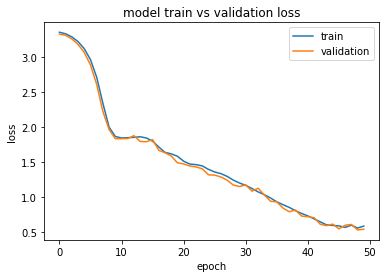

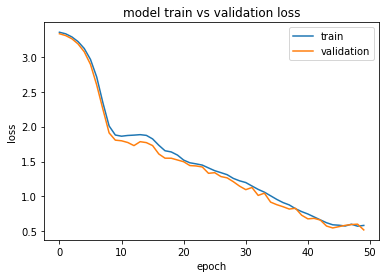

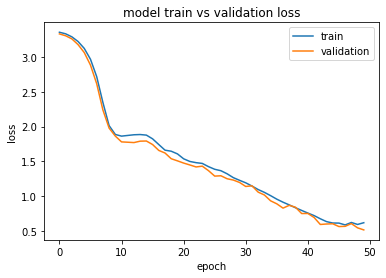

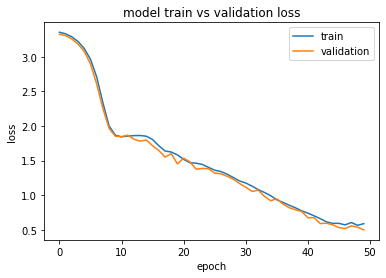

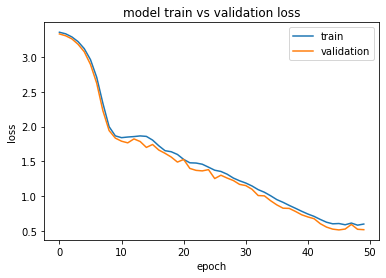

In [12]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

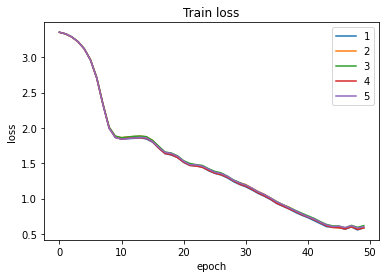

In [13]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

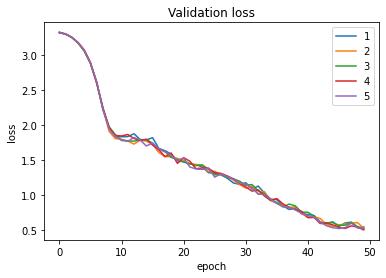

In [14]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

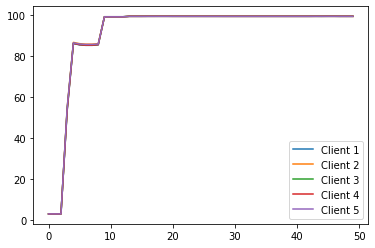

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

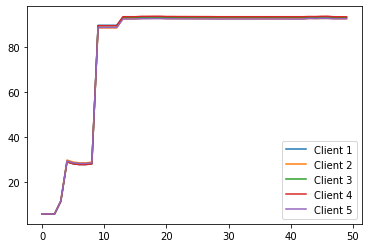

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()